# Quick Summary of Available PennDot Traffic Camera Data.
---------------------------------------------------------
PennDot operates 950 streaming video cameras throughout the state, with 12 in State College.  PennDot's official documentation can be found [here](https://www.penndot.gov/Doing-Business/OnlineServices/Pages/Developer-Resources.aspx)
and asks that users of the data complete a data request [form](https://expressforms.pa.gov/apps/pa/penndot/datafeed-request).

There are additional costs for the use of streaming video data, namely:
    * Establishing a "Business Partner Network connection," a one-time cost of $88.40.
    
    * Co-locate a router in their data center in Harriburg, a $380.00 monthly recurring cost. 
    
These stipulations are documented in [this](http://www.dot.state.pa.us/public/pdf/Technical_Requirements_to_access_video-FINAL.pdf) PDF document.   However, high-latency still images are available on the public web, and I used these to check car-couting feasibility, utility, and estimate data storage requirements.   Pulling images from three cameras located on Atherton, each sampled 4 times per minute, for a total of 225 minutes, required 42MB of storage space.  This works out to an average of approximately 12KB per image, which is the median file size I have observed.
Assuming we were sampling from the streaming video at one image per second, I would estimate 31GB would be required for each camera that was being recorded, every 30 days.

If we had a high degree of faith in our car-counting algorithim, this might not be required, as we may be able to simply record counts from each image.  I believed this might be something that could be investigated quickly.  As I already had traffic images from 4:30PM to 8:15PM Thursday night, I used a standard car-counting package to produce the following:

In [2]:
from platform import python_version
import tensorflow
import keras
import cv2
import matplotlib.pyplot as plt
import cvlib as cv
from cvlib.object_detection import draw_bbox

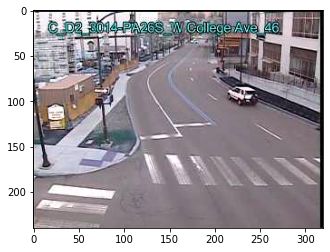

In [37]:
# Raw image from traffic camera located at intersection of West College and Atherton, looking South:

im = cv2.imread('/home/ubuntu/traffic/20200409_19_59_14_CAM02040CCTV46.jpg')
plt.imshow(im)
plt.show(None)

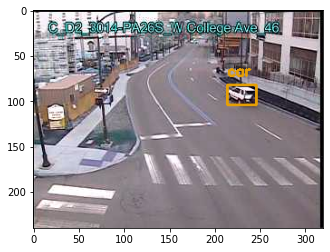

Number of cars in the image is 1


In [9]:
# Applying cvlib function and drawing bounding box:

bbox, label, conf = cv.detect_common_objects(im)
output_image = draw_bbox(im, bbox, label, conf)
plt.imshow(output_image)
plt.show()
print('Number of cars in the image is ' + str(label.count('car')))

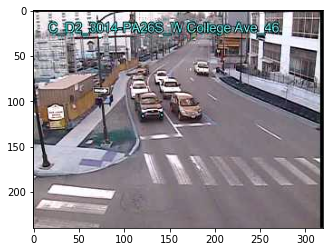

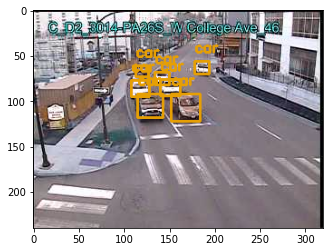

Number of cars in the image is 7


In [67]:
# Testing another image with a larger number of cars:

im = cv2.imread('/home/ubuntu/traffic/20200409_21_09_56_CAM02040CCTV46.jpg')
plt.imshow(im)
plt.show(None)
bbox, label, conf = cv.detect_common_objects(im)
output_image = draw_bbox(im, bbox, label, conf)
plt.imshow(output_image)
plt.show()
print('Number of cars in the image is ' + str(label.count('car')))

Details regarding application of the car-counting function to all images are at the bottom of this document, in what immediately follows we are working with the dataframe returned by iterating over all images.

In [69]:
import pandas as pd
df = pd.DataFrame(imcc, columns =[ 'DateTime', 'File','CarCount'])

In [70]:
df

,DateTime,File,CarCount
0,2020-04-09 21:14:14,/home/ubuntu/traffic/20200409_21_14_14_CAM0204...,4
1,2020-04-09 21:36:12,/home/ubuntu/traffic/20200409_21_36_12_CAM0204...,1
2,2020-04-09 21:26:52,/home/ubuntu/traffic/20200409_21_26_52_CAM0204...,2
3,2020-04-09 19:55:11,/home/ubuntu/traffic/20200409_19_55_11_CAM0204...,1
4,2020-04-09 23:28:02,/home/ubuntu/traffic/20200409_23_28_02_CAM0204...,3
...,...,...,...
879,2020-04-09 23:10:52,/home/ubuntu/traffic/20200409_23_10_52_CAM0204...,0
880,2020-04-09 21:43:32,/home/ubuntu/traffic/20200409_21_43_32_CAM0204...,4
881,2020-04-10 00:11:29,/home/ubuntu/traffic/20200410_00_11_29_CAM0204...,0
882,2020-04-10 00:14:00,/home/ubuntu/traffic/20200410_00_14_00_CAM0204...,0


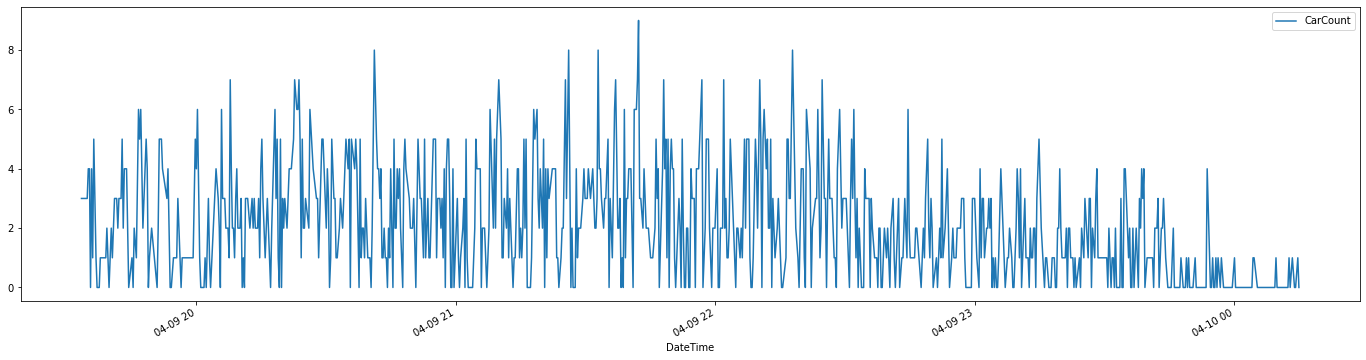

In [55]:
# Here we have the simplest possible visualization, a line chart of car counts between 4:30PM and 8:15PM.

# Traffic is of course greatly diminished, but the chart does indicate that the busiest period is from 5:30 to 6:30,
# and by 8PM, there are stretches of no traffic at all, occasionally interrupted by no more than one car.

# (Times in the plot are shifted by 3 hours from EST.) 

df.plot(x ='DateTime', y='CarCount', kind = 'line',figsize=(24,6))

In [47]:
# This code applies the cvlib function to all imges collected from the previously mentioned camera:

imcc = []

from datetime import datetime

x = glob.glob("/home/ubuntu/traffic/*TV46.jpg")
ims = x#[0:10]
for i in ims:
    if (os.stat(i).st_size > 9000):
        print(i)
        t = i.split("/")[4]
        t = t.split("CAM")[0]
        #print(t)
        d = datetime.strptime(t, '%Y%m%d_%H_%M_%S_')
        im = cv2.imread(i)
        if(type(im) == 'NoneType'):
            print("unreadable: ",i)
        else:
            bbox, label, conf = cv.detect_common_objects(im)
            cc = label.count('car')
            print(i,' '+ str(cc))
            imcc.append([d,i,cc])

/home/ubuntu/traffic/20200409_21_14_14_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_14_14_CAM02040CCTV46.jpg  4
/home/ubuntu/traffic/20200409_21_36_12_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_36_12_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_21_26_52_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_26_52_CAM02040CCTV46.jpg  2
/home/ubuntu/traffic/20200409_19_55_11_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_19_55_11_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_23_28_02_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_23_28_02_CAM02040CCTV46.jpg  3
/home/ubuntu/traffic/20200409_22_32_49_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_22_32_49_CAM02040CCTV46.jpg  3
/home/ubuntu/traffic/20200409_21_27_52_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_27_52_CAM02040CCTV46.jpg  4
/home/ubuntu/traffic/20200409_20_24_29_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_20_24_29_CAM02040CCTV46.jpg  5
/home/ubuntu/traffic/20200409_21_02_37_CAM02040C

/home/ubuntu/traffic/20200409_22_33_04_CAM02040CCTV46.jpg  0
/home/ubuntu/traffic/20200409_23_09_06_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_23_09_06_CAM02040CCTV46.jpg  0
/home/ubuntu/traffic/20200409_20_11_36_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_20_11_36_CAM02040CCTV46.jpg  3
/home/ubuntu/traffic/20200409_23_18_42_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_23_18_42_CAM02040CCTV46.jpg  0
/home/ubuntu/traffic/20200409_20_23_13_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_20_23_13_CAM02040CCTV46.jpg  6
/home/ubuntu/traffic/20200409_20_40_08_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_20_40_08_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_21_55_24_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_55_24_CAM02040CCTV46.jpg  0
/home/ubuntu/traffic/20200409_21_10_57_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_10_57_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_19_37_01_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_19_37_01_CAM02040C

/home/ubuntu/traffic/20200409_23_04_48_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_20_41_54_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_20_41_54_CAM02040CCTV46.jpg  4
/home/ubuntu/traffic/20200409_21_35_42_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_35_42_CAM02040CCTV46.jpg  3
/home/ubuntu/traffic/20200409_23_41_10_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_23_41_10_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_23_44_58_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_23_44_58_CAM02040CCTV46.jpg  0
/home/ubuntu/traffic/20200410_00_01_07_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200410_00_01_07_CAM02040CCTV46.jpg  0
/home/ubuntu/traffic/20200409_20_18_55_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_20_18_55_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_22_17_07_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_22_17_07_CAM02040CCTV46.jpg  3
/home/ubuntu/traffic/20200409_21_41_46_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_41_46_CAM02040C

/home/ubuntu/traffic/20200409_22_13_35_CAM02040CCTV46.jpg  2
/home/ubuntu/traffic/20200410_00_12_44_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200410_00_12_44_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_21_38_14_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_38_14_CAM02040CCTV46.jpg  0
/home/ubuntu/traffic/20200409_20_31_18_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_20_31_18_CAM02040CCTV46.jpg  5
/home/ubuntu/traffic/20200410_00_10_58_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200410_00_10_58_CAM02040CCTV46.jpg  0
/home/ubuntu/traffic/20200409_21_43_17_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_43_17_CAM02040CCTV46.jpg  2
/home/ubuntu/traffic/20200409_22_16_37_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_22_16_37_CAM02040CCTV46.jpg  5
/home/ubuntu/traffic/20200409_21_57_56_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_57_56_CAM02040CCTV46.jpg  5
/home/ubuntu/traffic/20200409_19_37_46_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_19_37_46_CAM02040C

/home/ubuntu/traffic/20200409_23_19_27_CAM02040CCTV46.jpg  2
/home/ubuntu/traffic/20200410_00_03_08_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200410_00_03_08_CAM02040CCTV46.jpg  0
/home/ubuntu/traffic/20200409_23_08_51_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_23_08_51_CAM02040CCTV46.jpg  0
/home/ubuntu/traffic/20200409_19_48_07_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_19_48_07_CAM02040CCTV46.jpg  4
/home/ubuntu/traffic/20200409_21_57_10_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_57_10_CAM02040CCTV46.jpg  0
/home/ubuntu/traffic/20200409_21_52_22_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_52_22_CAM02040CCTV46.jpg  5
/home/ubuntu/traffic/20200409_19_39_32_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_19_39_32_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_20_13_07_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_20_13_07_CAM02040CCTV46.jpg  2
/home/ubuntu/traffic/20200409_21_11_43_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_11_43_CAM02040C

/home/ubuntu/traffic/20200409_20_10_05_CAM02040CCTV46.jpg  2
/home/ubuntu/traffic/20200409_23_34_06_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_23_34_06_CAM02040CCTV46.jpg  0
/home/ubuntu/traffic/20200409_21_50_36_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_50_36_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_22_46_07_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_22_46_07_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_21_15_00_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_15_00_CAM02040CCTV46.jpg  2
/home/ubuntu/traffic/20200409_22_41_24_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_22_41_24_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_21_28_08_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_28_08_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_20_14_38_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_20_14_38_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_22_55_28_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_22_55_28_CAM02040C

/home/ubuntu/traffic/20200409_23_50_31_CAM02040CCTV46.jpg  0
/home/ubuntu/traffic/20200409_19_41_03_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_19_41_03_CAM02040CCTV46.jpg  3
/home/ubuntu/traffic/20200409_20_31_03_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_20_31_03_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_22_19_24_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_22_19_24_CAM02040CCTV46.jpg  0
/home/ubuntu/traffic/20200410_00_03_24_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200410_00_03_24_CAM02040CCTV46.jpg  0
/home/ubuntu/traffic/20200409_22_54_12_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_22_54_12_CAM02040CCTV46.jpg  0
/home/ubuntu/traffic/20200409_23_39_09_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_23_39_09_CAM02040CCTV46.jpg  4
/home/ubuntu/traffic/20200409_21_33_41_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_33_41_CAM02040CCTV46.jpg  3
/home/ubuntu/traffic/20200409_22_21_06_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_22_21_06_CAM02040C

/home/ubuntu/traffic/20200409_21_46_04_CAM02040CCTV46.jpg  2
/home/ubuntu/traffic/20200409_22_05_15_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_22_05_15_CAM02040CCTV46.jpg  2
/home/ubuntu/traffic/20200409_23_33_51_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_23_33_51_CAM02040CCTV46.jpg  3
/home/ubuntu/traffic/20200409_22_40_39_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_22_40_39_CAM02040CCTV46.jpg  2
/home/ubuntu/traffic/20200409_22_22_13_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_22_22_13_CAM02040CCTV46.jpg  0
/home/ubuntu/traffic/20200409_20_07_34_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_20_07_34_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_23_15_25_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_23_15_25_CAM02040CCTV46.jpg  2
/home/ubuntu/traffic/20200409_22_18_38_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_22_18_38_CAM02040CCTV46.jpg  2
/home/ubuntu/traffic/20200409_20_43_10_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_20_43_10_CAM02040C

/home/ubuntu/traffic/20200409_20_30_02_CAM02040CCTV46.jpg  2
/home/ubuntu/traffic/20200409_23_22_44_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_23_22_44_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_22_03_14_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_22_03_14_CAM02040CCTV46.jpg  2
/home/ubuntu/traffic/20200409_21_48_50_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_48_50_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_21_30_24_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_30_24_CAM02040CCTV46.jpg  3
/home/ubuntu/traffic/20200409_23_46_13_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_23_46_13_CAM02040CCTV46.jpg  0
/home/ubuntu/traffic/20200409_21_06_55_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_06_55_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_21_04_23_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_04_23_CAM02040CCTV46.jpg  2
/home/ubuntu/traffic/20200409_22_31_03_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_22_31_03_CAM02040C

/home/ubuntu/traffic/20200409_21_07_55_CAM02040CCTV46.jpg  6
/home/ubuntu/traffic/20200409_23_13_54_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_23_13_54_CAM02040CCTV46.jpg  2
/home/ubuntu/traffic/20200409_22_11_34_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_22_11_34_CAM02040CCTV46.jpg  5
/home/ubuntu/traffic/20200409_20_42_40_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_20_42_40_CAM02040CCTV46.jpg  4
/home/ubuntu/traffic/20200409_20_38_37_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_20_38_37_CAM02040CCTV46.jpg  2
/home/ubuntu/traffic/20200409_23_27_47_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_23_27_47_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_20_26_00_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_20_26_00_CAM02040CCTV46.jpg  2
/home/ubuntu/traffic/20200409_19_58_28_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_19_58_28_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_20_19_11_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_20_19_11_CAM02040C

/home/ubuntu/traffic/20200409_20_30_17_CAM02040CCTV46.jpg  4
/home/ubuntu/traffic/20200409_20_58_20_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_20_58_20_CAM02040CCTV46.jpg  5
/home/ubuntu/traffic/20200409_19_36_00_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_19_36_00_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_23_59_21_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_23_59_21_CAM02040CCTV46.jpg  0
/home/ubuntu/traffic/20200409_20_32_18_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_20_32_18_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_23_32_35_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_23_32_35_CAM02040CCTV46.jpg  2
/home/ubuntu/traffic/20200409_21_25_36_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_25_36_CAM02040CCTV46.jpg  3
/home/ubuntu/traffic/20200409_23_17_41_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_23_17_41_CAM02040CCTV46.jpg  0
/home/ubuntu/traffic/20200409_20_08_34_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_20_08_34_CAM02040C

/home/ubuntu/traffic/20200409_21_21_18_CAM02040CCTV46.jpg  4
/home/ubuntu/traffic/20200410_00_02_38_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200410_00_02_38_CAM02040CCTV46.jpg  0
/home/ubuntu/traffic/20200409_21_16_46_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_16_46_CAM02040CCTV46.jpg  0
/home/ubuntu/traffic/20200409_20_38_22_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_20_38_22_CAM02040CCTV46.jpg  2
/home/ubuntu/traffic/20200409_20_06_33_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_20_06_33_CAM02040CCTV46.jpg  3
/home/ubuntu/traffic/20200409_21_42_31_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_42_31_CAM02040CCTV46.jpg  3
/home/ubuntu/traffic/20200409_23_18_11_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_23_18_11_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_22_03_29_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_22_03_29_CAM02040CCTV46.jpg  5
/home/ubuntu/traffic/20200410_00_07_56_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200410_00_07_56_CAM02040C

/home/ubuntu/traffic/20200409_21_56_55_CAM02040CCTV46.jpg  7
/home/ubuntu/traffic/20200409_20_47_28_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_20_47_28_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_22_26_15_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_22_26_15_CAM02040CCTV46.jpg  5
/home/ubuntu/traffic/20200409_20_38_07_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_20_38_07_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_21_48_05_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_48_05_CAM02040CCTV46.jpg  7
/home/ubuntu/traffic/20200409_21_13_44_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_13_44_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_21_39_14_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_21_39_14_CAM02040CCTV46.jpg  1
/home/ubuntu/traffic/20200409_22_28_16_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200409_22_28_16_CAM02040CCTV46.jpg  4
/home/ubuntu/traffic/20200410_00_05_55_CAM02040CCTV46.jpg
/home/ubuntu/traffic/20200410_00_05_55_CAM02040C

In [68]:
# Here we sort counts by the date and time of the image was captured:
sorted(imcc, key = lambda x: x[1])

[[datetime.datetime(2020, 4, 9, 19, 33, 24),
  '/home/ubuntu/traffic/20200409_19_33_24_CAM02040CCTV46.jpg',
  3],
 [datetime.datetime(2020, 4, 9, 19, 34, 44),
  '/home/ubuntu/traffic/20200409_19_34_44_CAM02040CCTV46.jpg',
  3],
 [datetime.datetime(2020, 4, 9, 19, 34, 59),
  '/home/ubuntu/traffic/20200409_19_34_59_CAM02040CCTV46.jpg',
  4],
 [datetime.datetime(2020, 4, 9, 19, 35, 15),
  '/home/ubuntu/traffic/20200409_19_35_15_CAM02040CCTV46.jpg',
  4],
 [datetime.datetime(2020, 4, 9, 19, 35, 30),
  '/home/ubuntu/traffic/20200409_19_35_30_CAM02040CCTV46.jpg',
  0],
 [datetime.datetime(2020, 4, 9, 19, 35, 45),
  '/home/ubuntu/traffic/20200409_19_35_45_CAM02040CCTV46.jpg',
  4],
 [datetime.datetime(2020, 4, 9, 19, 36),
  '/home/ubuntu/traffic/20200409_19_36_00_CAM02040CCTV46.jpg',
  1],
 [datetime.datetime(2020, 4, 9, 19, 36, 15),
  '/home/ubuntu/traffic/20200409_19_36_15_CAM02040CCTV46.jpg',
  5],
 [datetime.datetime(2020, 4, 9, 19, 36, 46),
  '/home/ubuntu/traffic/20200409_19_36_46_CAM02